## Experiment 4
#### Evaluate the performance of implemented three-layer neural network with variations in activation functions, size of hidden layer, learning rate, batch size and number of epochs

In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.metrics import confusion_matrix

In [2]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
batch_size = 10
epochs = 50

In [9]:
activations = {'relu': tf.nn.relu, 'tanh': tf.nn.tanh, 'sigmoid': tf.nn.sigmoid}
hidden_layer_sizes = [256, 128, 64]

# Dataset
def preprocess(image, label):
    image = tf.reshape(image, [784])
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, 10)
    return image, label

train_data = (
        tf.data.Dataset.from_tensor_slices((X_train, y_train))
        .map(preprocess)
        .shuffle(60000)
        .batch(batch_size)
        .cache()
        .prefetch(tf.data.AUTOTUNE)
    )

test_data = (
        tf.data.Dataset.from_tensor_slices((X_test, y_test))
        .map(preprocess)
        .batch(batch_size)
        .cache()
        .prefetch(tf.data.AUTOTUNE)
    )

In [10]:
def train_and_evaluate(hidden_size, activation_func, learning_rate=1e-1):
    start_time = time.time()

    # model parameters
    input_dim = 784
    num_classes = 10

    weights = {
        "h1": tf.Variable(tf.random.normal([input_dim, hidden_size]), trainable=True),
        "out": tf.Variable(tf.random.normal([hidden_size, num_classes]), trainable=True)
    }
    biases = {
        "b1": tf.Variable(tf.random.normal([hidden_size]), trainable=True),
        "out": tf.Variable(tf.random.normal([num_classes]), trainable=True)
    }

    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    loss_fn = lambda y_true, y_pred: tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_true, y_pred))

    # Training loop
    loss_history, accuracy_history = [], []
    with tf.device('/GPU:0'):
        for epoch in range(epochs):
            epoch_loss, correct_preds, total_samples = 0, 0, 0
            for batch_x, batch_y in train_data:
                with tf.GradientTape() as tape:
                    hidden_layer = activation_func(tf.add(tf.matmul(batch_x, weights["h1"]), biases["b1"]))
                    logits = tf.add(tf.matmul(hidden_layer, weights["out"]), biases["out"])
                    loss = loss_fn(batch_y, logits)

                gradients = tape.gradient(loss, list(weights.values()) + list(biases.values()))
                optimizer.apply_gradients(zip(gradients, list(weights.values()) + list(biases.values())))

                epoch_loss += loss.numpy()
                correct_preds += tf.reduce_sum(tf.cast(tf.argmax(logits, 1) == tf.argmax(batch_y, 1), tf.float32)).numpy()
                total_samples += batch_y.shape[0]

            epoch_loss /= len(X_train) // batch_size
            epoch_acc = correct_preds / total_samples
            loss_history.append(epoch_loss)
            accuracy_history.append(epoch_acc)

    print(f"Completed: Hidden Units={hidden_size}, Activation={activation_func.__name__}, LR={learning_rate}")

    # Evaluate on test data
    y_true, y_pred = [], []
    correct_preds, total_samples = 0, 0

    for test_images, test_labels in test_data:
        hidden_layer = activation_func(tf.add(tf.matmul(test_images, weights["h1"]), biases["b1"]))
        logits = tf.add(tf.matmul(hidden_layer, weights["out"]), biases["out"])
        preds = tf.argmax(logits, 1)

        y_true.extend(np.argmax(test_labels.numpy(), axis=1))
        y_pred.extend(preds.numpy())

        correct_preds += tf.reduce_sum(tf.cast(preds == tf.argmax(test_labels, 1), tf.float32)).numpy()
        total_samples += test_labels.shape[0]

    test_acc = correct_preds / total_samples
    cm = confusion_matrix(y_true, y_pred)

    # Execution time
    execution_time = time.time() - start_time

    return loss_history, accuracy_history, test_acc, cm, execution_time



In [11]:
results = []

for activation_name, activation in activations.items():
    for hidden_size in hidden_layer_sizes:
          loss, acc, test_acc, cm, exec_time = train_and_evaluate(hidden_size, activation)
          results.append([hidden_size, activation_name, loss[-1], acc[-1], test_acc, cm, exec_time])

Completed: Hidden Units=256, Activation=relu, LR=0.1
Completed: Hidden Units=128, Activation=relu, LR=0.1
Completed: Hidden Units=64, Activation=relu, LR=0.1
Completed: Hidden Units=256, Activation=tanh, LR=0.1
Completed: Hidden Units=128, Activation=tanh, LR=0.1
Completed: Hidden Units=64, Activation=tanh, LR=0.1
Completed: Hidden Units=256, Activation=sigmoid, LR=0.1
Completed: Hidden Units=128, Activation=sigmoid, LR=0.1
Completed: Hidden Units=64, Activation=sigmoid, LR=0.1


In [12]:
columns = ["Hidden Layers", "Activation", "Final Loss", "Final Accuracy", "Test Accuracy", "Confusion Matrix", "Execution Time"]


neuralMetrics = pd.DataFrame(results, columns=columns)
display(neuralMetrics)

,Hidden Layers,Activation,Final Loss,Final Accuracy,Test Accuracy,Confusion Matrix,Execution Time
0,256,relu,0.333706,0.927117,0.9215,"[[961, 1, 0, 0, 1, 1, 2, 1, 2, 11], [0, 1107, ...",159.523354
1,128,relu,0.320840,0.927567,0.8415,"[[951, 0, 0, 2, 0, 0, 2, 1, 24, 0], [0, 1103, ...",152.873286
2,64,relu,0.333636,0.927100,0.9212,"[[966, 0, 1, 1, 0, 0, 2, 2, 8, 0], [0, 1092, 5...",146.296201
3,256,tanh,0.622607,0.912033,0.9249,"[[966, 0, 4, 1, 2, 3, 2, 0, 1, 1], [0, 1127, 3...",152.848629
4,128,tanh,0.351757,0.921100,0.9139,"[[960, 0, 5, 0, 4, 0, 0, 2, 9, 0], [0, 1101, 7...",154.515376
5,64,tanh,0.300579,0.920617,0.9332,"[[960, 0, 1, 2, 2, 1, 7, 1, 4, 2], [0, 1110, 4...",147.467038
6,256,sigmoid,0.266243,0.943633,0.9373,"[[963, 0, 1, 1, 2, 0, 6, 1, 5, 1], [0, 1115, 1...",155.130387
7,128,sigmoid,0.184496,0.949967,0.9416,"[[965, 0, 1, 1, 0, 0, 1, 5, 4, 3], [1, 1102, 4...",157.935284
8,64,sigmoid,0.177577,0.948667,0.9485,"[[955, 0, 3, 1, 0, 3, 2, 7, 5, 4], [0, 1115, 6...",159.792149


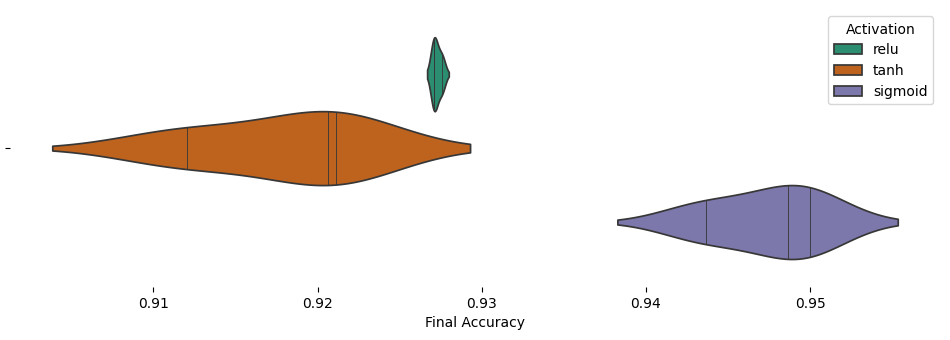

In [ ]:
figsize = (12, 1.2 * len(neuralMetrics['Activation'].unique()))
plt.figure(figsize=figsize);
sns.violinplot(neuralMetrics, x='Final Accuracy', hue='Activation', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

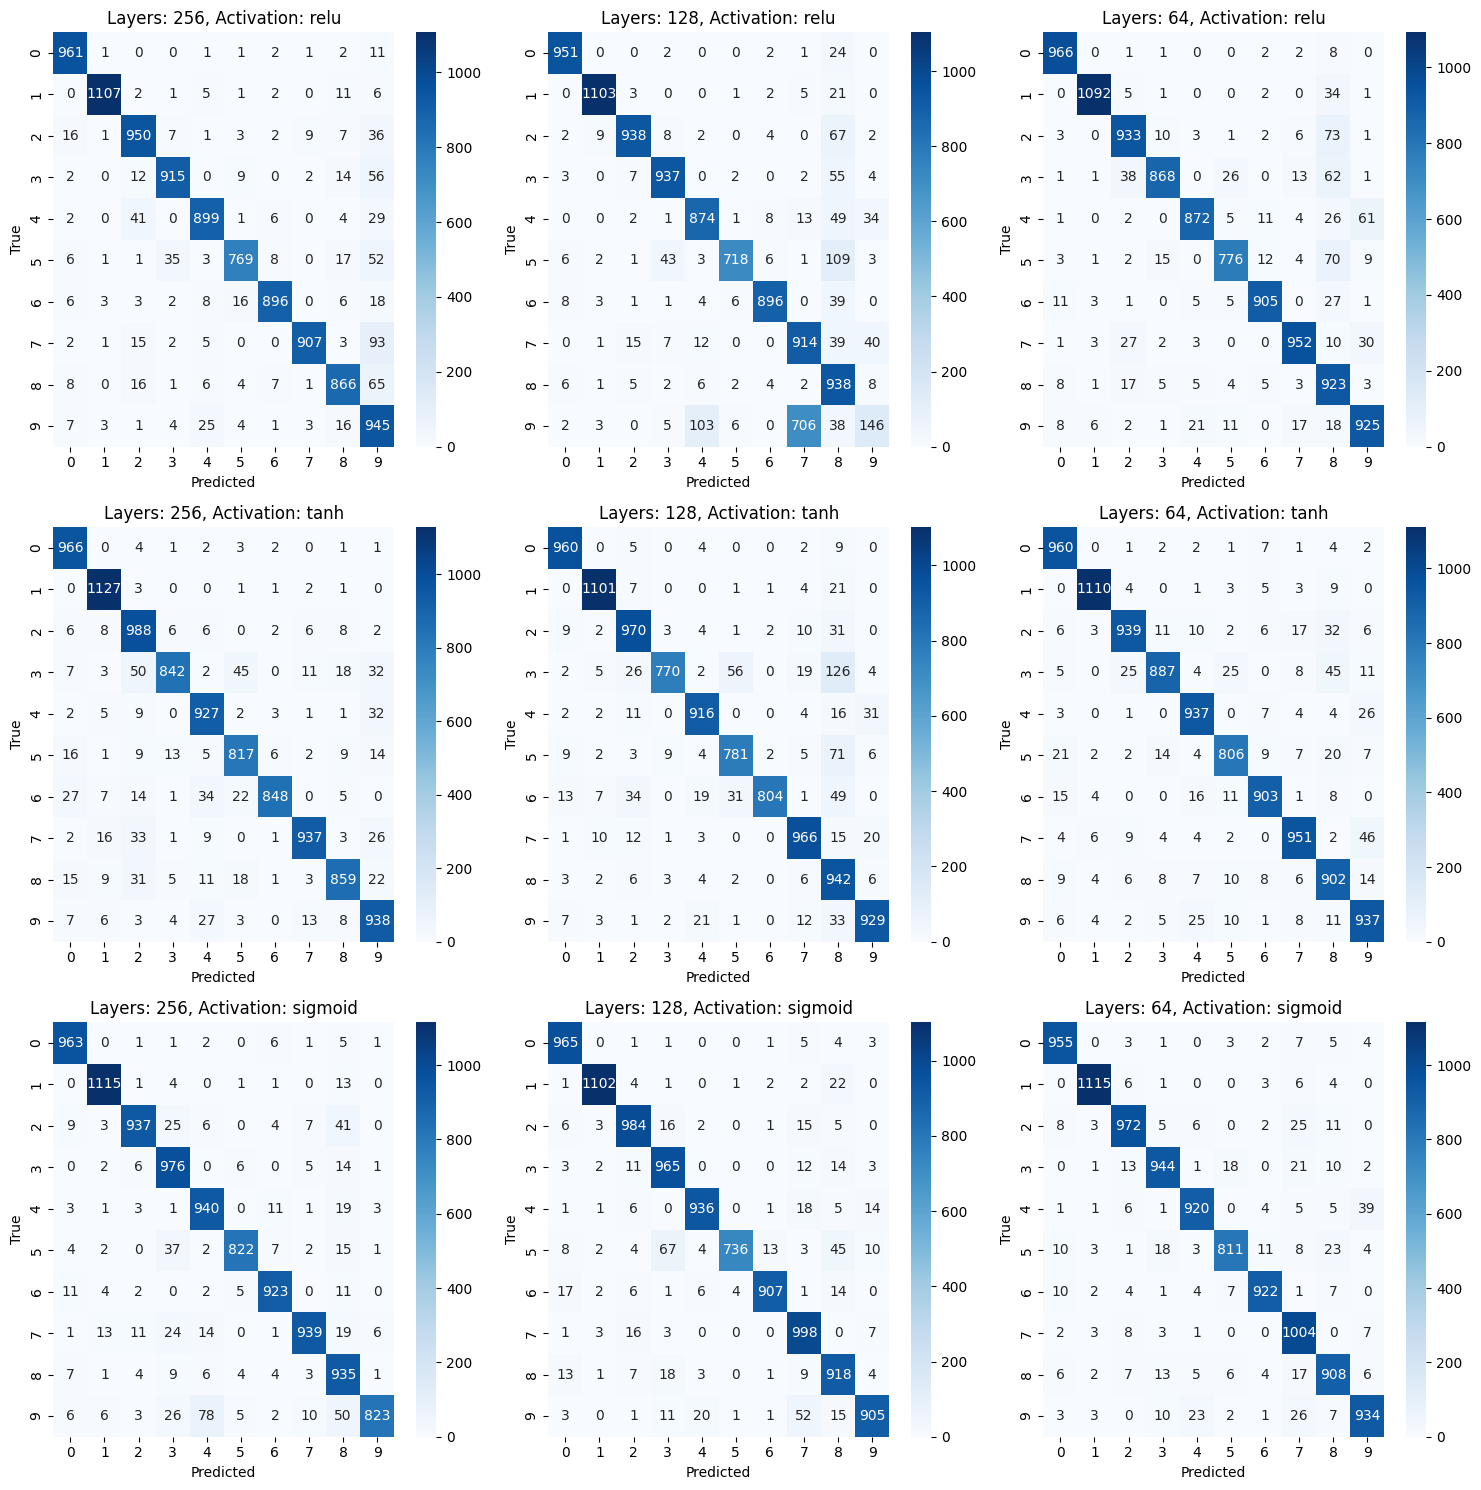

In [21]:
trials = neuralMetrics.shape[0]

rows = int(np.ceil(np.sqrt(trials)))
cols = int(np.ceil(trials / rows))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = np.array(axes)

for i in range(trials):
    row, col = divmod(i, cols)
    ax = axes[row, col] if rows > 1 else axes[col]

    matrix = neuralMetrics['Confusion Matrix'][i]
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", ax=ax)

    ax.set_title(f"Layers: {neuralMetrics['Hidden Layers'][i]}, Activation: {neuralMetrics['Activation'][i]}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

for j in range(i + 1, rows * cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

## **Model Description**  

##### **Training Combinations**  
- Learning rate and hidden layer configurations are dynamically adjustable.  

##### **Data Preprocessing**  
- **Pixel values** are scaled to the **[0, 1]** range.  
- Images are reshaped into 784-dimensional vectors.  
- Labels are **one-hot encoded** for multi-class classification.  

##### **Input Layer**  
- The input layer consists of **784 neurons**, one for each pixel in a **28×28** grayscale image.  

##### **Hidden Layers**  
- The model supports **single hidden layers**, with sizes specified dynamically.  
- Each layer uses:  
  - **Random normal initialization**  for stable weight distribution.  
  - **ReLU, Sigmoid, Tanh activation functions**  for non-linearity.  

##### **Output Layer**  
- The output layer consists of **10 neurons**, one for each possible digit (0-9).  
- Outputs **raw logits**, which are passed to the softmax cross-entropy loss function.  

##### **Loss Function**  
- **Softmax cross-entropy loss**  is used to compare the logits with one-hot encoded labels.  

##### **Optimizer**  
- **Adam optimizer**  is used for efficient gradient updates.  
- Learning rate is dynamically adjustable (default **0.1**).  

##### **Training Process**  
- The model trains over **50 epochs** with a **batch size of 10**.  
- Uses **mini-batch gradient descent** with backpropagation.  
- Training is performed on **GPU if available**.  
- **Automatic differentiation** computes gradients.  
- Loss and accuracy are **tracked per epoch** and stored in history lists.  

##### **Performance Evaluation**  
- **Test accuracy** is computed after training using the test dataset.  
- Model predictions are compared to true labels using **accuracy calculations**.  
- **Confusion matrix** is generated to evaluate classification performance.  

##### **Visualization & Metrics**  
- **Confusion matrix** is visualized for detailed performance evaluation.  
- **Execution time** is measured from start to finish.

## **Code Description**  

##### **Data Loading and Preprocessing**  
- **Loading MNIST**: The MNIST dataset, containing **28×28 grayscale images** of handwritten digits (0-9), is loaded using `tf.data.Dataset.from_tensor_slices`. The dataset is divided into **training** and **test** sets.  
- **Normalization**: Pixel values are **scaled between [0,1]** by dividing each pixel by 255.0.  
- **Reshaping**: Images are reshaped from **28×28 (2D)** into **1D arrays of size 784 (28 × 28)**.  
- **One-Hot Encoding**: The target labels are converted into **one-hot encoded vectors** of length **10**, where each digit corresponds to an index with a value of **1** and the rest **0**.  

##### **Model Definition**  
- A **custom neural network** is implemented using TensorFlow's `tf.Variable` and `tf.matmul` functions.  
- The model consists of **multiple hidden layers**, dynamically defined based on user input.  
- **Each hidden layer includes**:  
  - **Fully connected layers** initialized using **random normal initialization**.  
  - **ReLU activation function** for non-linearity.  
- **Output Layer**:  
  - A fully connected layer that maps from the last hidden layer to **10 output units** (one per digit).  
  - Returns **raw logits** (no softmax activation is applied at this stage).  

##### **Loss Function and Optimizer**  
- **Loss Function**: `tf.nn.softmax_cross_entropy_with_logits` is used to compute the cross-entropy between true **one-hot encoded labels** and raw logits.  
- **Optimizer**: The **Adam optimizer** is used for gradient descent optimization with a **configurable learning rate** (default **0.1**).  

##### **Training Function**  
- The training function iterates over the **training dataset**, performing **batch-wise updates**.  
- Training process:  
  1. **Forward pass**: Computes activations through all layers.  
  2. **Loss computation**: Computes softmax cross-entropy loss.  
  3. **Gradient computation**: Uses to compute gradients.  
  4. **Parameter update**: Applies gradients using the **Adam optimizer**.  
  5. **Accuracy tracking**: Keeps track of training loss and accuracy per epoch.  

##### **Evaluation Function**  
- **Evaluate function**: Measures test accuracy after training.  
- **Softmax activation**: Converts logits into probabilities to predict class labels.  
- **Accuracy computation**: Compares predicted class labels with **true labels**.  

##### **Training Loop**  
- The training loop runs for specified epochs and iterates over mini-batches of the training dataset.  
- Training is executed on **GPU (`/GPU:0`)** if available.  
- **Per epoch**:  
  1. **Processes batches of size**.  
  2. **Computes loss and updates weights**.  
  3. **Stores accuracy and loss history**.  
  4. **Evaluates the model on the test set**.  

##### **Training Time**  
- Training execution time is measured by recording timestamps **before and after** training.  

##### **Visualization**  
- **Loss Curve**: A plot of the loss over **epochs** to visualize training progress.  
- **Accuracy Curve**: A plot of the accuracy over **epochs** to monitor performance.  

##### **Confusion Matrix**  
- The trained model is evaluated on the test set.  
- A **confusion matrix** is computed to analyze misclassification patterns.  
- The confusion matrix is **visualized using a heatmap** for better interpretation.